In [1]:
source = './images/1.jpg'
evaluate = True
weights = './train/weights/best.pt'
imgsz=(640, 640)  # inference size (height, width)
conf_thres=0.25  # confidence threshold
iou_thres=0.45  # NMS IOU threshold
max_det=1000  # maximum detections per image
classes=None  # filter by class: --class 0, or --class 0 2 3
agnostic_nms=False  # class-agnostic NMS

In [2]:
import os
import torch
import cv2
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
model = torch.hub.load('..', 'custom', path=weights, device='cpu', source='local')
model.conf = conf_thres # NMS confidence threshold
model.iou = iou_thres  # NMS IoU threshold

YOLOv5 🚀 2023-5-7 Python-3.7.16 torch-1.13.1+cu117 CPU



In [4]:
img = cv2.imread(source)
results = model(img,size=imgsz)

TypeError: forward() got an unexpected keyword argument 'size'

In [ ]:
results_pandas = results.pandas().xyxy[0]

In [ ]:
type(results_pandas)

pandas.core.frame.DataFrame

In [ ]:
results_dict = results_pandas.set_index('name').T.to_dict('list')

In [ ]:
results_dict['bottom_right']

[579.5194091796875,
 499.2857666015625,
 622.52783203125,
 554.5380859375,
 0.8343579769134521,
 1.0]

post-process

In [ ]:
import numpy as np

In [ ]:
def get_center_point(coordinate_dict):
    di = dict()

    for key in coordinate_dict.keys():
        xmin, ymin, xmax, ymax,conf,idx = coordinate_dict[key]
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2
        di[key] = [x_center, y_center]

    return di

In [ ]:
di = get_center_point(results_dict)

In [ ]:
a = {'bottom_right', 'top_right', 'top_left', 'bottom_left'}
b = {'bottom_right':1, 'top_right':2, 'top_left':3}

In [ ]:
list(a - set(b.keys()))

['bottom_left']

In [ ]:
def find_miss_corner(coordinate_dict):
    ref = {'bottom_right', 'top_right', 'top_left', 'bottom_left'}
    source = set(coordinate_dict.keys())
    diff = list(ref - source)

    return diff

In [ ]:
def calculate_missed_coord_corner(coordinate_dict):
    thresh = 0

    diff = find_miss_corner(coordinate_dict)

    if len(diff) > 1:
        print("Cannot Align Image, try to choose another one")
        exit(0)
    if len(diff) == 0:
        return coordinate_dict

    miss = diff[0]
    # calculate missed corner coordinate
    if miss == 'top_left':
        midpoint = np.add(coordinate_dict['top_right'], coordinate_dict['bottom_left']) / 2
        y = 2 * midpoint[1] - coordinate_dict['bottom_right'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['bottom_right'][0] - thresh
        coordinate_dict['top_left'] = [x, y]
    elif miss == 'top_right':
        midpoint = np.add(coordinate_dict['top_left'], coordinate_dict['bottom_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['bottom_left'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['bottom_left'][0] - thresh
        coordinate_dict['top_right'] = [x, y]
    elif miss == 'bottom_right':
        midpoint = np.add(coordinate_dict['bottom_left'], coordinate_dict['top_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['top_left'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['top_left'][0] - thresh
        coordinate_dict['bottom_right'] = [x, y]
    elif miss == 'bottom_left':
        midpoint = np.add(coordinate_dict['top_left'], coordinate_dict['bottom_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['top_right'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['top_right'][0] - thresh
        coordinate_dict['bottom_left'] = [x, y]

    return coordinate_dict

In [ ]:
full_corners = calculate_missed_coord_corner(di)
full_corners

{'bottom_right': [601.0236206054688, 526.9119262695312],
 'top_right': [584.8165893554688, 94.75206756591797],
 'top_left': [66.47538757324219, 90.69892120361328],
 'bottom_left': [53.019052505493164, 552.1229858398438]}

In [ ]:
a = full_corners['bottom_left']
a

[53.019052505493164, 552.1229858398438]

In [ ]:
np.array(list(full_corners.values()))

array([[     601.02,      526.91],
       [     584.82,      94.752],
       [     66.475,      90.699],
       [     53.019,      552.12]])

In [ ]:
def perspective_transform(image, source_points):
    top_left = list(map(int, source_points['top_left']))
    top_right = list(map(int, source_points['top_right']))
    bottom_right = list(map(int, source_points['bottom_right']))
    bottom_left = list(map(int, source_points['bottom_left']))

    source_points = np.float32([top_left, top_right, bottom_right, bottom_left])
    dest_points = np.float32([[0, 0], [640, 0], [640, 640], [0, 640]])
    M = cv2.getPerspectiveTransform(source_points, dest_points)
    dst = cv2.warpPerspective(image, M, (640,640))

    return dst

In [ ]:
dst = perspective_transform(img, full_corners)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

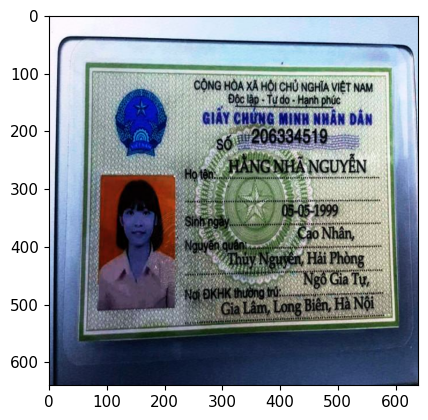

In [ ]:
plt.imshow(img)
plt.show()

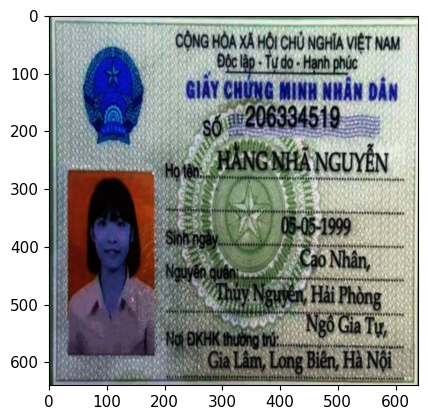

In [ ]:
plt.imshow(dst)
plt.show()